Data analysis for PLR-3000 data
===============================

After bluetoothing accross, open the excel spreadsheet and save it in CSV format. Then run the code below.

In [1]:
import numpy as np
import pandas as pd

#plr3000 = pd.read_csv(
#    r'C:/Users/engs2242/Desktop/PLR-3000/R_20210312_132224.csv')
plr3000 = pd.read_csv(
    r'C:\Users\engs2242\Documents\PyPlr\cvd_pupillometry\examples\PFR\data\neuroptics\R_20210329_133726.csv')

In [2]:
plr3000

,Record ID,Device ID,Patient ID,Time,MeasurementType,Pupil Measured,ABN,Static Measurement Duration,Static Led in uW,Static Mean,...,Unnamed: 824,Unnamed: 825,Unnamed: 826,Unnamed: 827,Unnamed: 828,Unnamed: 829,Unnamed: 830,Unnamed: 831,Unnamed: 832,Unnamed: 833
0,141,3PK200021,0,29/03/2021 13:26,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
1,140,3PK200021,0,29/03/2021 13:24,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
2,139,3PK200021,0,29/03/2021 13:23,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
3,138,3PK200021,0,29/03/2021 13:22,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
4,137,3PK200021,0,29/03/2021 13:21,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
5,136,3PK200021,0,29/03/2021 13:18,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
6,135,3PK200021,0,29/03/2021 13:17,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
7,132,3PK200021,0,29/03/2021 13:13,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
8,131,3PK200021,0,29/03/2021 13:12,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
9,130,3PK200021,0,29/03/2021 13:11,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1


Seperate raw data from summary information
------------------------------------------

In [3]:
info = []
raw_data = []
for idx, row in plr3000.iterrows():
    information = row[[col for col in plr3000.columns if not 'Unnamed' in col]]
    raw = row[[col for col in plr3000.columns if 'Unnamed' in col]]
    dl = information['Data Length']
    time = raw.iloc[0:dl].to_numpy()
    pupil = raw.iloc[dl:dl*2].to_numpy()
    valid = raw.iloc[dl*2:dl*3].to_numpy()
    df = pd.DataFrame({'onset': time,
                       'diameter': pupil,
                       'valid': valid}, dtype=float)
    df['Record ID'] = information['Record ID']
    df['Patient ID'] = information['Patient ID']
    raw_data.append(df)
    info.append(information.to_frame().T)

info = pd.concat(info).set_index(['Record ID'])
raw_data = pd.concat(raw_data).set_index(['Record ID', 'onset'])
# set invalid samples to nan
raw_data.loc[raw_data.valid==0, 'diameter'] = np.nan
raw_data['diameter_pc'] = ((raw_data['diameter']/info['PLR Diameter Init'])-1) *100

In [4]:
raw_data.diameter_pc

Record ID  onset
117        0.000   -1.86885
           0.033   -1.39344
           0.067   -1.45902
           0.100   -1.83607
           0.134   -1.59016
                     ...   
55         9.826   -11.8033
           9.860   -11.6721
           9.893   -11.6557
           9.926   -11.6721
           9.960   -11.2787
Name: diameter_pc, Length: 18239, dtype: object

In [4]:
info

,Device ID,Patient ID,Time,MeasurementType,Pupil Measured,ABN,Static Measurement Duration,Static Led in uW,Static Mean,Static Std,...,PLR Pulse Led in uW,PLR Bkg Led in uW,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75,Data Length
Record ID,,,,,,,,,,,,,,,,,,,,,
141,3PK200021,0,29/03/2021 13:26,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.1,2.7,0.2,-3.95,-6.27,1.11,2.37,270
140,3PK200021,0,29/03/2021 13:24,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.3,2.7,0.2,-3.5,-6.43,1,2.47,270
139,3PK200021,0,29/03/2021 13:23,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.6,2.8,0.2,-4.12,-6.57,0.95,NaN,270
138,3PK200021,0,29/03/2021 13:22,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.5,2.8,0.23,-3.52,-6.23,0.75,4.34,270
137,3PK200021,0,29/03/2021 13:21,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.9,3,0.2,-3.48,-6.07,1.09,5.05,270
136,3PK200021,0,29/03/2021 13:18,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.3,2.6,0.23,-3.43,-6.45,0.95,5.92,270
135,3PK200021,0,29/03/2021 13:17,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.4,2.7,0.2,-3.7,-6.27,1,4.11,270
132,3PK200021,0,29/03/2021 13:13,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.1,2.7,0.2,-3.16,-5.4,1.35,2.94,270
131,3PK200021,0,29/03/2021 13:12,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.2,2.8,0.23,-3.24,-5.83,1.13,2.47,270


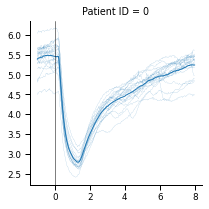

In [117]:
import seaborn as sns
data = raw_data.reset_index()
data.onset = data.onset-1
g = sns.FacetGrid(data=data, col='Patient ID')
g.map_dataframe(sns.lineplot, x='onset', y='diameter', estimator=None, units='Record ID', lw=.1)
g.map_dataframe(sns.lineplot, x='onset', y='diameter',  lw=1, ci=None)
for ax in g.axes[0]:
    ax.axvline(0, c='k', lw=.5)

In [103]:
import os
import os.path as op
import pandas as pd
datapath = r'C:\Users\engs2242\Documents\PyPlr\cvd_pupillometry\examples\PFR\data\pyplr'
subs = os.listdir(datapath)
cols = ['diameter','diameter_3d','timestamp','confidence']
trials=[]
for sub in subs:
    subpath = op.join(datapath, sub)
    for rec in os.listdir(subpath):
        recpath = op.join(subpath, rec)
        data = pd.read_csv(op.join(recpath, 'raw_data.csv'), index_col='timestamp', usecols=cols)
        data['onset'] =  range(len(data))
        data['onset'] =  data['onset'] * 1/120-1
        data['subject'] = sub
        data['rec'] = rec
        trials.append(data.reset_index())
        
trials = pd.concat(trials).reset_index(drop=True).rename(columns={'index':'onset'})

In [104]:
data

,diameter,confidence,diameter_3d,onset,subject,rec
timestamp,,,,,,
251799.066814,38.930203,1.0,3.150494,-1.000000,000,020
251799.074567,38.929320,1.0,3.149992,-0.991667,000,020
251799.082466,38.728766,1.0,3.149783,-0.983333,000,020
251799.090514,38.872169,1.0,3.149895,-0.975000,000,020
251799.102542,38.922411,1.0,3.150350,-0.966667,000,020
...,...,...,...,...,...,...
251807.750784,39.416832,1.0,3.173661,7.958333,000,020
251807.758578,39.480565,1.0,3.170498,7.966667,000,020
251807.766735,39.309212,1.0,3.167366,7.975000,000,020


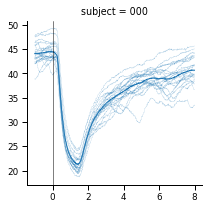

In [118]:
g = sns.FacetGrid(data=trials, col='subject')
g.map_dataframe(sns.lineplot, x='onset', y='diameter', estimator=None, units='rec', lw=.1)
g.map_dataframe(sns.lineplot, x='onset', y='diameter', ci=None, lw=1)

for ax in g.axes[0]:
    ax.axvline(0, c='k', lw=.5)


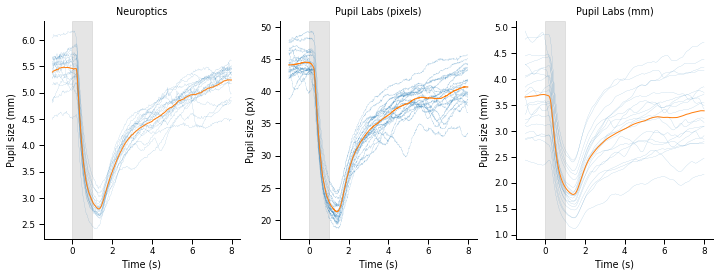

In [144]:
sns.set_context('paper')
fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.lineplot(data=data, x='onset', y='diameter', estimator=None, units='Record ID', lw=.1, ax=axs[0])
sns.lineplot(data=data, x='onset', y='diameter', ci=None, lw=1, ax=axs[0])
axs[0].set_title('Neuroptics')
axs[0].set_ylabel('Pupil size (mm)')
sns.lineplot(data=trials, x='onset', y='diameter', estimator=None, units='rec', lw=.1, ax=axs[1])
sns.lineplot(data=trials, x='onset', y='diameter', ci=None, lw=1, ax=axs[1])
axs[1].set_title('Pupil Labs (pixels)')
axs[1].set_ylabel('Pupil size (px)')
sns.lineplot(data=trials, x='onset', y='diameter_3d', estimator=None, units='rec', lw=.1, ax=axs[2])
sns.lineplot(data=trials, x='onset', y='diameter_3d', ci=None, lw=1, ax=axs[2])
axs[2].set_title('Pupil Labs (mm)')
axs[2].set_ylabel('Pupil size (mm)')

for ax in axs:
    ax.axvspan(0,1,color='k', alpha=.1)
    ax.set_xlabel('Time (s)')
sns.despine(fig)